Here

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("noamaanabdulazeem/cauliflower-dataset")

print("Path to dataset files:", path)

100%|██████████| 1.44G/1.44G [00:16<00:00, 93.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/noamaanabdulazeem/cauliflower-dataset/versions/1


In [ ]:
import os

original_dataset_path = "/root/.cache/kagglehub/datasets/noamaanabdulazeem/cauliflower-dataset/versions/1/Original Dataset"
print("Classes:", os.listdir(original_dataset_path))


Classes: ['No disease', 'Bacterial spot rot', 'Downy Mildew', 'Black Rot']


In [ ]:
# Step 2: Define paths
dataset_path = "/root/.cache/kagglehub/datasets/noamaanabdulazeem/cauliflower-dataset/versions/1/Original Dataset"
output_dir = "/root/cauliflower_leaf_disease_split"

# Step 3: Create train/val directories
for split in ['train', 'val']:
    for class_name in os.listdir(dataset_path):
        os.makedirs(os.path.join(output_dir, split, class_name), exist_ok=True)

In [ ]:
import os

# Define dataset and output paths
dataset_path = "/root/.cache/kagglehub/datasets/noamaanabdulazeem/cauliflower-dataset/versions/1/Original Dataset"
output_dir = "/root/cauliflower_leaf_disease_split"

# Create train/val directories for each class
for split in ['train', 'val']:
    for class_name in os.listdir(dataset_path):
        class_dir = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_dir):  # Ensure it's a directory
            os.makedirs(os.path.join(output_dir, split, class_name), exist_ok=True)

print("Train and val directories created successfully!")


Train and val directories created successfully!


In [ ]:
import shutil
from sklearn.model_selection import train_test_split

# Split data into train and val sets (80-20 split)
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        images = os.listdir(class_dir)
        train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

        # Copy images to respective train/val folders
        for img in train_images:
            shutil.copy(os.path.join(class_dir, img), os.path.join(output_dir, 'train', class_name))
        for img in val_images:
            shutil.copy(os.path.join(class_dir, img), os.path.join(output_dir, 'val', class_name))


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(output_dir, 'train'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(output_dir, 'val'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)


Found 523 images belonging to 4 classes.
Found 133 images belonging to 4 classes.


In [ ]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax')  # 4 classes
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_labels = train_generator.classes
class_weights = compute_class_weight('balanced', classes=np.unique(class_labels), y=class_labels)
class_weights = dict(enumerate(class_weights))

print("Class Weights:", class_weights)


Class Weights: {0: 0.947463768115942, 1: 1.634375, 2: 0.9273049645390071, 3: 0.7972560975609756}


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=[early_stopping, model_checkpoint]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 0.2856 - loss: 1.5658 - val_accuracy: 0.4211 - val_loss: 1.1807
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.4023 - loss: 1.1895 - val_accuracy: 0.5714 - val_loss: 0.9553
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.5263 - loss: 1.0344 - val_accuracy: 0.6391 - val_loss: 0.9338
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.5775 - loss: 0.9233 - val_accuracy: 0.6767 - val_loss: 0.8312
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.6437 - loss: 0.8015 - val_accuracy: 0.5714 - val_loss: 0.8819
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.6468 - loss: 0.7288 - val_accuracy: 0.6767 - val_loss: 0.6445
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step - accuracy: 0.6520 - loss: 0.7368 - val_accuracy: 0.7519 - val_loss: 0.6359
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.7133 - loss: 0.6429 - val_accuracy: 0.7519 - val_loss:

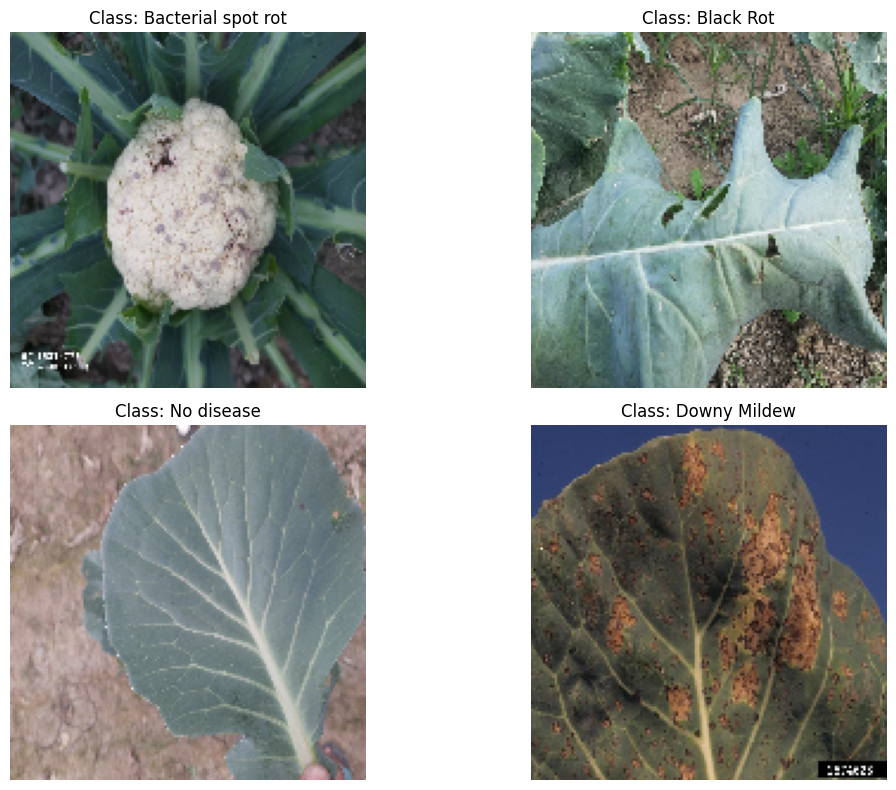

In [ ]:
import matplotlib.pyplot as plt
import os
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Path to your dataset's 'val' folder
val_path = os.path.join(output_dir, 'val')

# Display a few random images from each class
classes = os.listdir(val_path)
plt.figure(figsize=(12, 8))

for i, class_name in enumerate(classes):
    class_folder = os.path.join(val_path, class_name)
    image_name = random.choice(os.listdir(class_folder))
    image_path = os.path.join(class_folder, image_name)

    img = load_img(image_path, target_size=(150, 150))
    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.title(f"Class: {class_name}")
    plt.axis('off')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


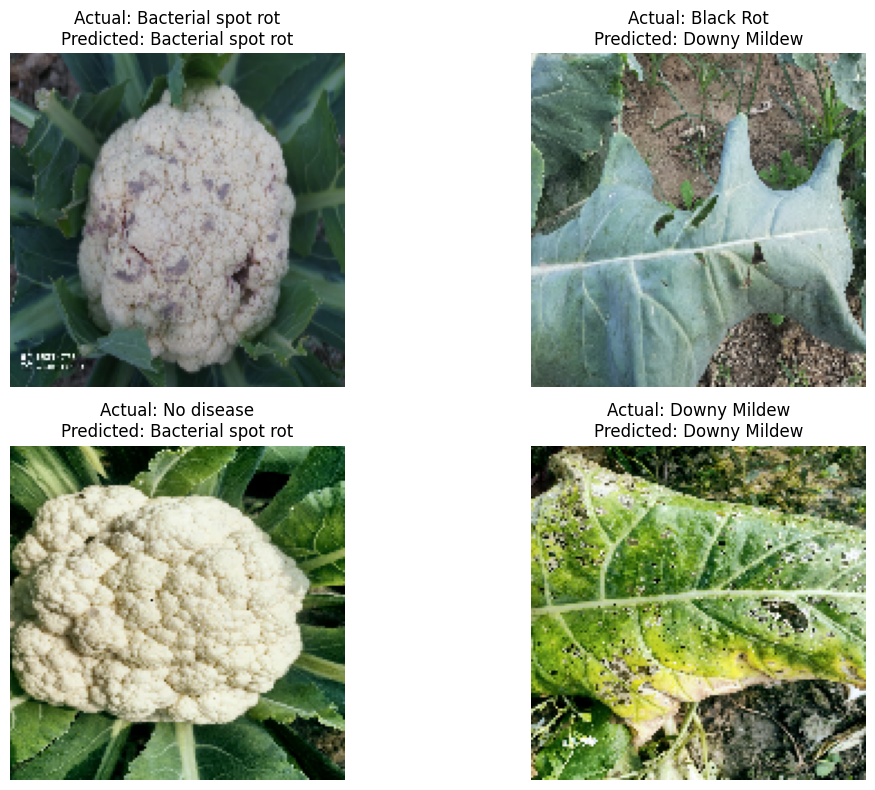

In [ ]:
import numpy as np

# Load and preprocess a test image
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(150, 150))
    img_array = img_to_array(img) / 255.0
    return np.expand_dims(img_array, axis=0)

# Map class indices to class names
class_indices = train_generator.class_indices
class_labels = {v: k for k, v in class_indices.items()}

# Display predictions
plt.figure(figsize=(12, 8))

for i, class_name in enumerate(classes):
    class_folder = os.path.join(val_path, class_name)
    image_name = random.choice(os.listdir(class_folder))
    image_path = os.path.join(class_folder, image_name)

    img_array = preprocess_image(image_path)
    prediction = model.predict(img_array)
    predicted_class = class_labels[np.argmax(prediction)]

    # Plot the image and prediction
    img = load_img(image_path, target_size=(150, 150))
    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.title(f"Actual: {class_name}\nPredicted: {predicted_class}")
    plt.axis('off')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step


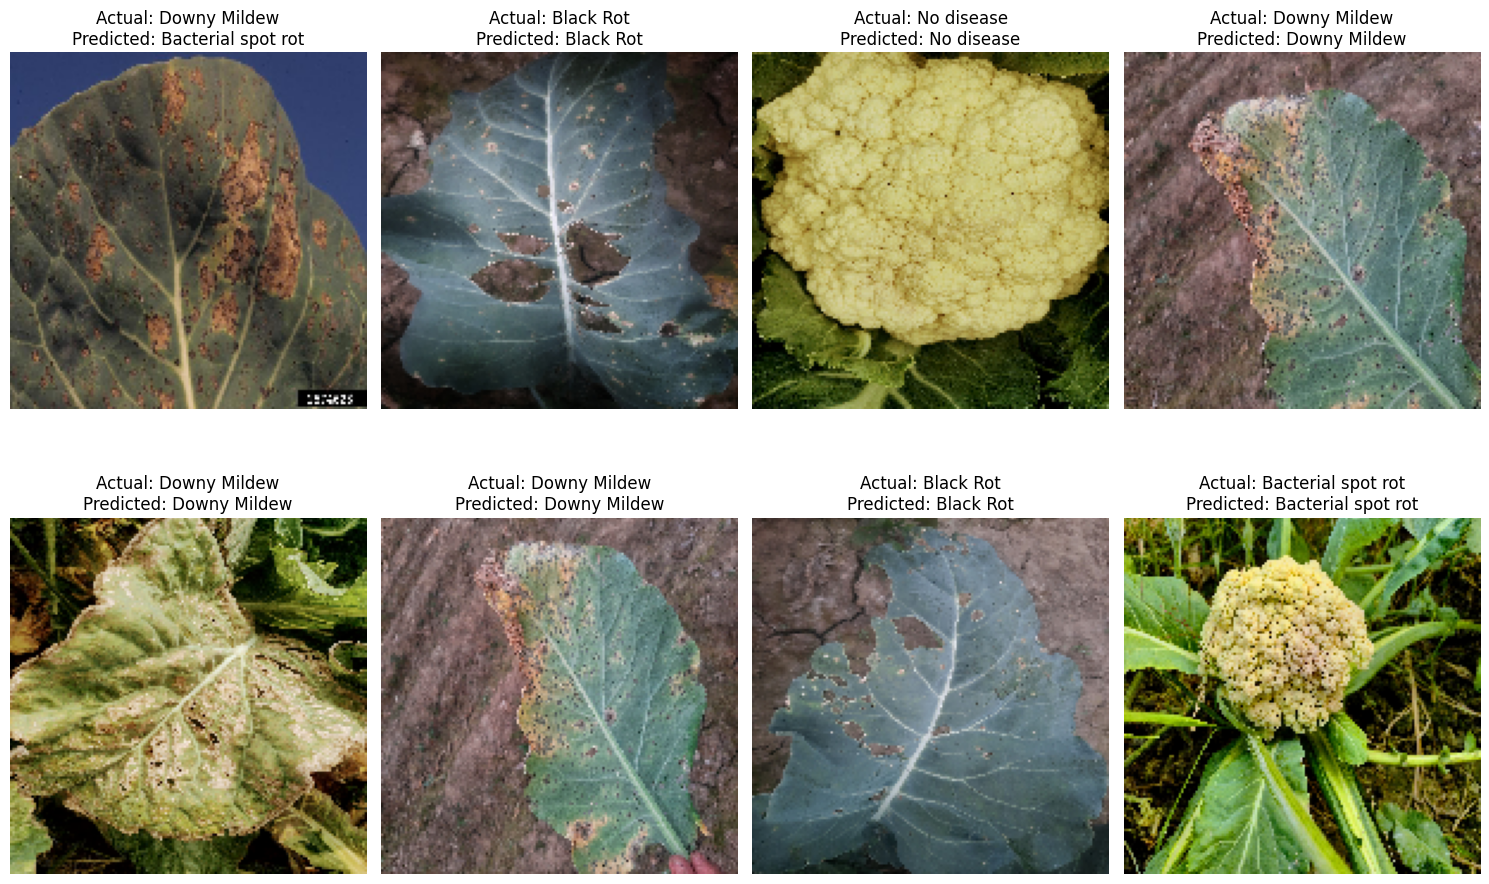

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to plot images with actual vs predicted labels
def plot_predictions(model, test_generator, class_indices, num_images=8):
    plt.figure(figsize=(15, 10))
    class_labels = {v: k for k, v in class_indices.items()}

    batch = next(test_generator)
    images, labels = batch
    preds = model.predict(images)
    predicted_classes = np.argmax(preds, axis=1)
    actual_classes = np.argmax(labels, axis=1)

    for i in range(num_images):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i])
        actual_label = class_labels[actual_classes[i]]
        predicted_label = class_labels[predicted_classes[i]]
        plt.title(f'Actual: {actual_label}\nPredicted: {predicted_label}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display 8 predictions
plot_predictions(model, val_generator, train_generator.class_indices, num_images=8)


Final Training Accuracy: 0.87
Final Validation Accuracy: 0.86


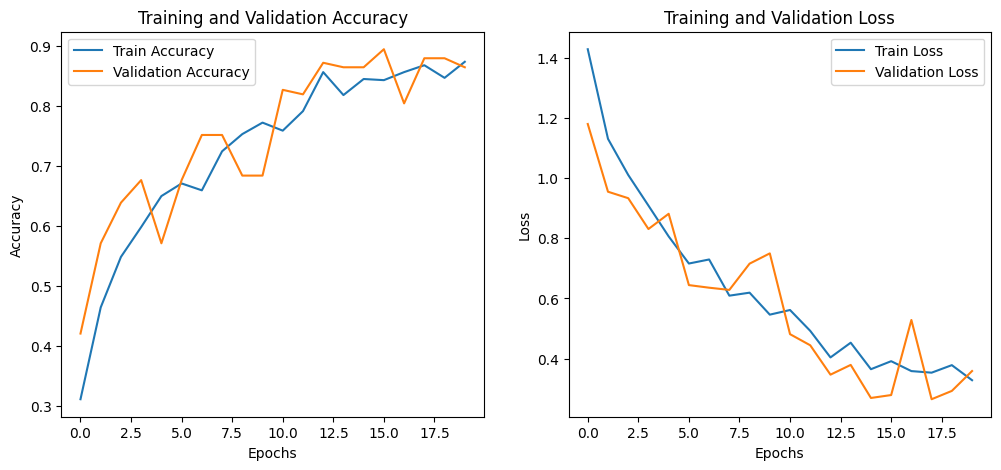

In [ ]:
import matplotlib.pyplot as plt

# Print final training and validation accuracy
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
print(f"Final Training Accuracy: {final_train_acc:.2f}")
print(f"Final Validation Accuracy: {final_val_acc:.2f}")

# Plot training & validation accuracy and loss graphs
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
# Ensure that the target_size in test_generator matches the input shape of your model
test_generator = val_datagen.flow_from_directory(
    os.path.join(output_dir, 'val'),
    target_size=(150, 150),  # Adjust to match your model's input shape (150, 150)
    batch_size=32,
    class_mode='categorical'
)

# ... (rest of your code) ...

# Now, when you call model.predict(test_generator), the input shapes should align
y_pred = model.predict(test_generator)

Found 133 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step


5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step


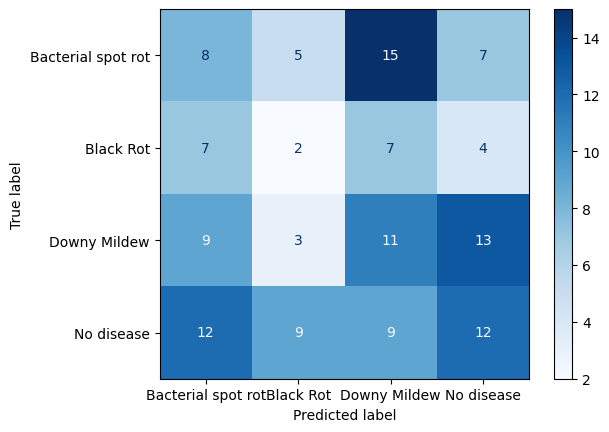

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get the true labels and predicted labels
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap='Blues')
plt.show()


Found 656 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - loss: 0.0637
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - loss: 0.0576
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step - loss: 0.0527
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - loss: 0.0491
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - loss: 0.0474
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - loss: 0.0473
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - loss: 0.0466
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - loss: 0.0488
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 77s 4s/step - loss: 0.0480
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - loss: 0.0468
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - loss: 0.0464
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - loss: 0.0463
Epoch 13/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - loss: 0.0468
Epoch 14/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - loss: 0.0471
Epoch 15/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - loss: 0.0473
Epoch 16/50
21/21 ━

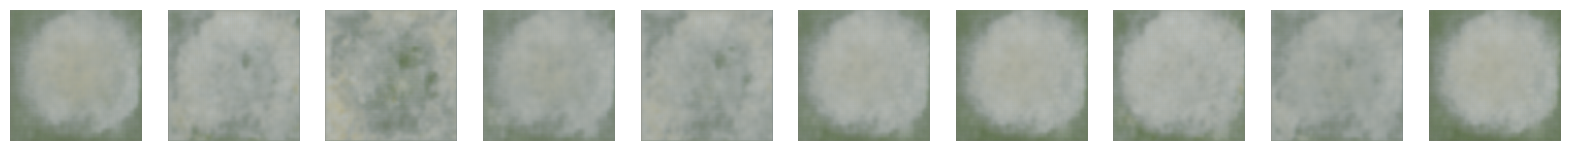

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os

# Load and preprocess cauliflower leaf dataset
img_height, img_width = 128, 128
batch_size = 32

dataset_dir = '/root/.cache/kagglehub/datasets/noamaanabdulazeem/cauliflower-dataset/versions/1/Original Dataset'
datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='input'
)

# VAE model
latent_dim = 2

class VAE(keras.Model):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = self.build_encoder(latent_dim)
        self.decoder = self.build_decoder(latent_dim)

    def build_encoder(self, latent_dim):
        inputs = keras.Input(shape=(img_height, img_width, 3))
        x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(inputs)
        x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
        x = layers.Flatten()(x)
        x = layers.Dense(16, activation='relu')(x)
        z_mean = layers.Dense(latent_dim, name='z_mean')(x)
        z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
        return keras.Model(inputs, [z_mean, z_log_var], name='encoder')

    def build_decoder(self, latent_dim):
        inputs = keras.Input(shape=(latent_dim,))
        x = layers.Dense(32 * 32 * 64, activation='relu')(inputs)
        x = layers.Reshape((32, 32, 64))(x)
        x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
        x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
        outputs = layers.Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)
        return keras.Model(inputs, outputs, name='decoder')

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
        z = z_mean + tf.exp(0.5 * z_log_var) * epsilon
        reconstructed = self.decoder(z)
        return reconstructed

# Compile and train VAE
vae = VAE(latent_dim)
vae.compile(optimizer=keras.optimizers.Adam(), loss='mse')
vae.fit(train_generator, epochs=50)

# Generate synthetic images
def plot_images(model, n=10):
    random_latent_vectors = tf.random.normal(shape=(n, latent_dim))
    generated_images = model.decoder(random_latent_vectors)
    generated_images *= 255
    generated_images = np.clip(generated_images.numpy(), 0, 255).astype('uint8')

    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.show()

plot_images(vae)


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow as tf

# Hyperparameters
latent_dim = 128  # increase latent size for richer representations

# Encoder
inputs = Input(shape=(128, 128, 3))
x = Conv2D(64, 3, strides=2, padding="same", activation="relu")(inputs)
x = Conv2D(128, 3, strides=2, padding="same", activation="relu")(x)
x = Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
x = Flatten()(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

# Reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling)([z_mean, z_log_var])

# Decoder
decoder_input = Input(shape=(latent_dim,))
x = Dense(16 * 16 * 256, activation="relu")(decoder_input)
x = Reshape((16, 16, 256))(x)
x = Conv2DTranspose(128, 3, strides=2, padding="same", activation="relu")(x)
x = Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
outputs = Conv2DTranspose(3, 3, strides=2, padding="same", activation="sigmoid")(x)

# Models
encoder = Model(inputs, [z_mean, z_log_var, z], name="encoder")
decoder = Model(decoder_input, outputs, name="decoder")

# VAE loss
def vae_loss(y_true, y_pred):
    reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(y_true, y_pred), axis=(1, 2)))
    kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var))
    return reconstruction_loss + 0.001 * kl_loss  # Adjust weight of KL term

# VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name="vae")
vae.compile(optimizer="adam", loss=vae_loss)

vae.summary()


Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder (Functional)                 │ [(None, 128), (None, 128),  │      17,148,288 │
│                                      │ (None, 128)]                │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 128, 128, 3)         │       8,824,707 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,972,995 (99.08 MB)

 Trainable params: 25,972,995 (99.08 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
perceptual_loss = K.mean(K.square(vgg_features - decoder_output))
loss = reconstruction_loss + kl_loss + 0.1 * perceptual_loss

NameError: name 'vgg_features' is not defined

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


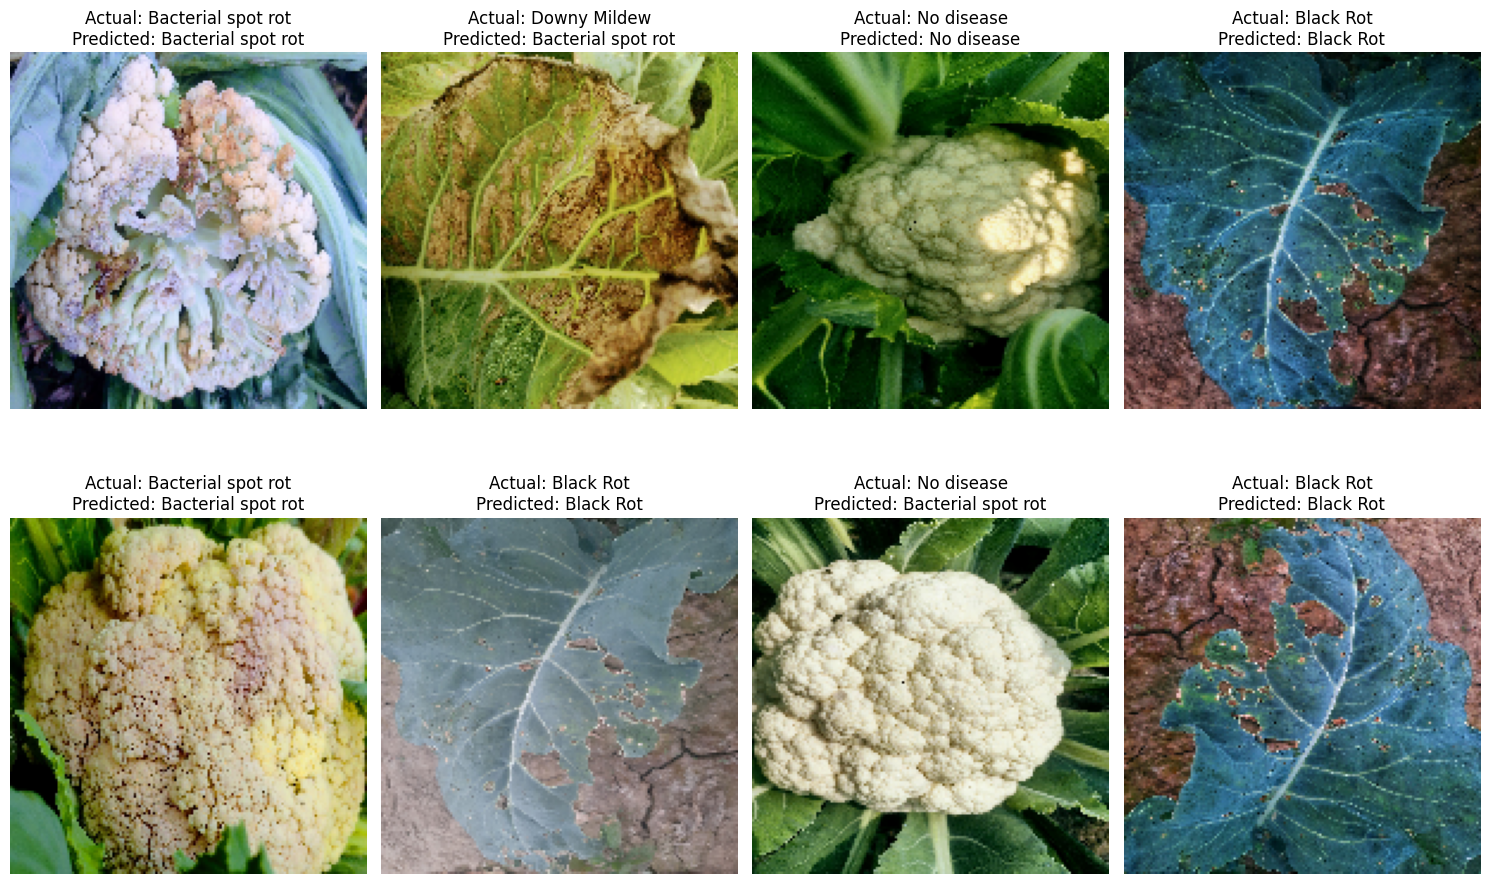

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to plot images with actual vs predicted labels
def plot_predictions(model, test_generator, class_indices, num_images=8):
    plt.figure(figsize=(15, 10))
    class_labels = {v: k for k, v in class_indices.items()}

    batch = next(test_generator)
    images, labels = batch
    preds = model.predict(images)
    predicted_classes = np.argmax(preds, axis=1)
    actual_classes = np.argmax(labels, axis=1)

    for i in range(num_images):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i])
        actual_label = class_labels[actual_classes[i]]
        predicted_label = class_labels[predicted_classes[i]]
        plt.title(f'Actual: {actual_label}\nPredicted: {predicted_label}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display 8 predictions
plot_predictions(model, val_generator, train_generator.class_indices, num_images=8)


In [ ]:
# DCGAN